In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tifffile as tiff 
from tqdm.auto import tqdm

class config:
    BASE_PATH = "../input/hubmap-organ-segmentation/"
    TRAIN_PATH = os.path.join(BASE_PATH, "train")

#Loading train df
df = pd.read_csv(
    os.path.join(config.BASE_PATH, "train.csv")
)
display(df.head())
df.info()

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex  
0    Male  
1    Male  
2    Male  
3    Male  
4  Female

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                351 non-null    int64  
 1   organ             351 non-null    object 
 2   data_source       351 non-null    object 
 3   img_height        351 non-null    int64  
 4   img_width         351 non-null    int64  
 5   pixel_size        351 non-null    float64
 6   tissue_thickness  351 non-null    int64  
 7   rle               351 non-null    object 
 8   age               351 non-null    float64
 9   sex               351 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 27.5+ KB


(3000, 3000, 3)


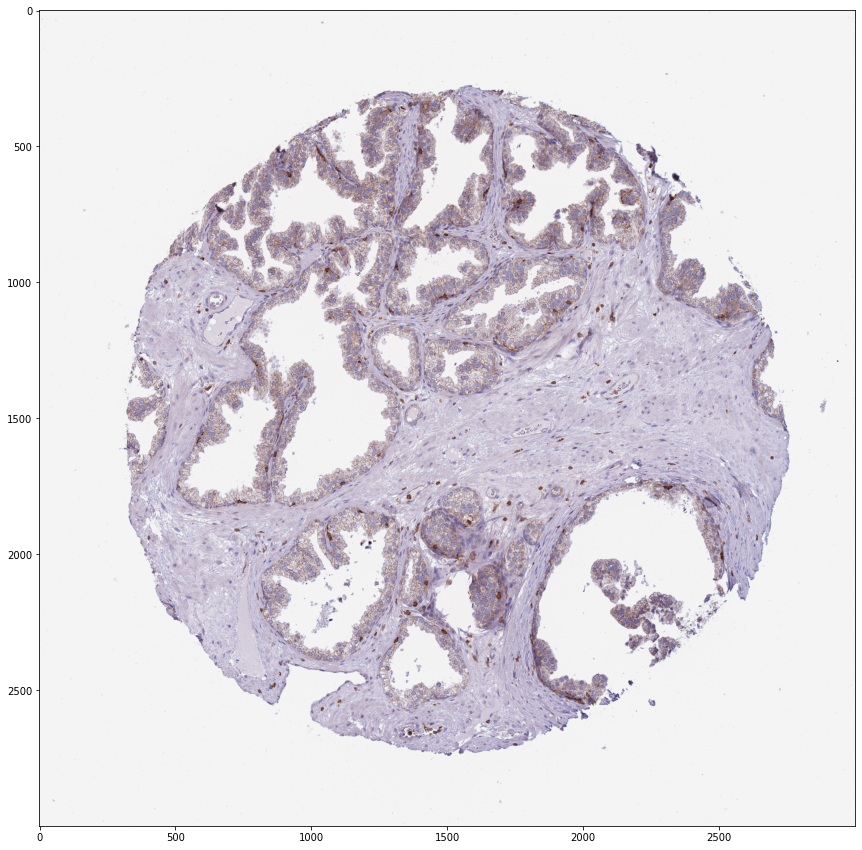

In [2]:
img_id_1 = 10044
img_1 = tiff.imread(config.BASE_PATH + "train_images/" + str(img_id_1) + ".tiff")
print(img_1.shape)
plt.figure(figsize=(15, 15))
plt.imshow(img_1)
# plt.axis("off")

(2023, 2023, 3)


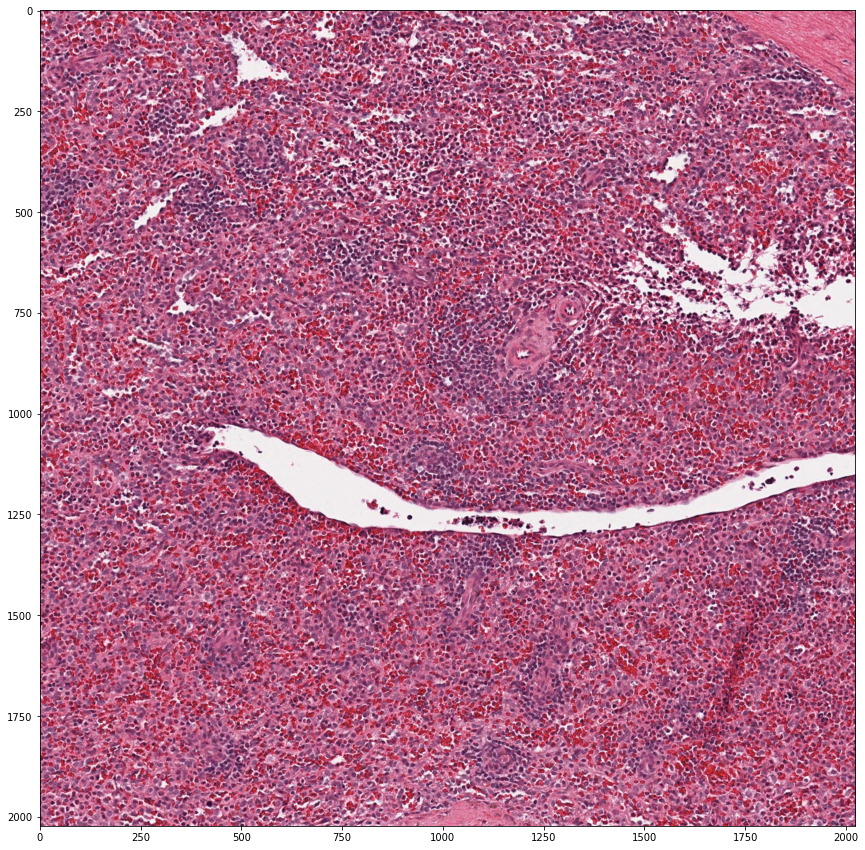

In [3]:
img_id_t1 = 10078
img_t1 = tiff.imread(config.BASE_PATH + "test_images/" + str(img_id_t1) + ".tiff")
print(img_t1.shape)
plt.figure(figsize=(15, 15))
plt.imshow(img_t1)
# plt.axis("off")

In [4]:
# Reference: https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
# functions to convert encoding to mask and mask to encoding
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [5]:
mask_1 = rle2mask(df[df["id"]==img_id_1]["rle"].iloc[-1], (img_1.shape[1], img_1.shape[0]))
mask_1.shape

(3000, 3000)

(-0.5, 2999.5, 2999.5, -0.5)

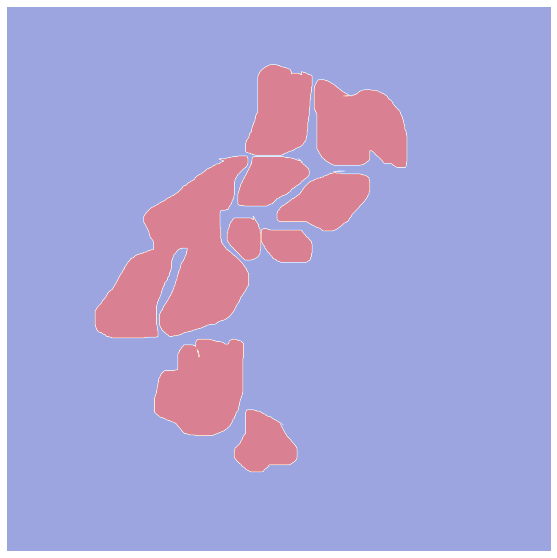

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")

(-0.5, 2999.5, 2999.5, -0.5)

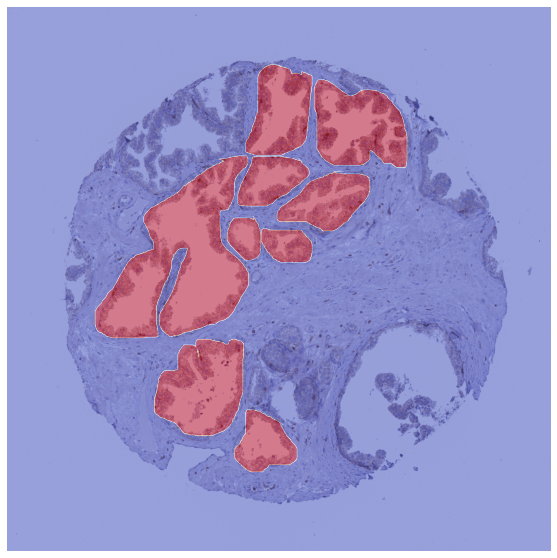

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(img_1)
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")

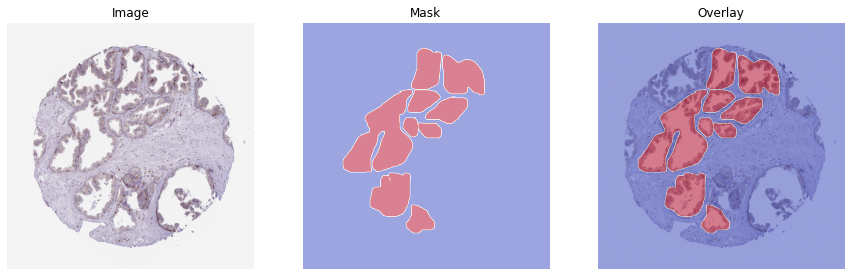

In [8]:
f, axarr = plt.subplots(1,3, figsize=(15,15))#3 

axarr[0].imshow(img_1)
axarr[1].imshow(mask_1, cmap='coolwarm', alpha=0.5)
axarr[2].imshow(img_1)
axarr[2].imshow(mask_1, cmap='coolwarm', alpha=0.5)
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].set_title("Image")
axarr[1].set_title("Mask")
axarr[2].set_title("Overlay")

# f.tight_layout()
f.savefig('overlay.png', dpi=300)

---

In [14]:
df[['img_height', 'img_width']].value_counts().sort_values(ascending=False)

img_height  img_width
3000        3000         326
2942        2942           2
2631        2631           2
2654        2654           2
2790        2790           2
2416        2416           2
2764        2764           2
2680        2680           1
2511        2511           1
2539        2539           1
2593        2593           1
2630        2630           1
2675        2675           1
2783        2783           1
2760        2760           1
2727        2727           1
2867        2867           1
2869        2869           1
2308        2308           1
3070        3070           1
dtype: int64